In [54]:
%pip install -r requirements.txt
%matplotlib inline

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build turicreate
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for turicreate (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [31 lines of output]
      running bdist_wheel
      running build
      installing to build\bdist.win-amd64\wheel
      running install
      
      
      
              TURICREATE ERROR
      
              If you see this message, pip install did not find an available binary package
              for your system.
      
              Supported Platforms:
                  * macOS 10.12+ x86_64.
                  * Linux x86_64 (including WSL on Windows 10).
      
              Support Python Versions:
                  * 2.7
                  * 3.5
                  * 3.6
                  * 3.7
                  * 3.8
      
              Another possible cause of this error is an outdated pip version. Try:
                  `pip install -U pip`
      
      
      
      
      [end of output]
  
  note: This error originates from a subproc

In [55]:
# This is a simple program that will compute gradient of a variable

from typing import Set


class GradientNumber:

    def __init__(self, value : float, children: Set['GradientNumber'] = set(), operator: str = "" ):
        self.value = value
        self.gradient = 0.0
        self.children = children
        self.operator = operator
        self._backward = lambda: None
    
    def __add__(self, other):
        if not isinstance(other, GradientNumber):
            other = GradientNumber(other)

        output = GradientNumber(self.value + other.value, {self, other}, operator=f'+')

        def _backward():
            self.gradient += 1.0 * output.gradient
            other.gradient += 1.0 * output.gradient

        output._backward = _backward
        return output
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        if not isinstance(other, GradientNumber):
            other = GradientNumber(other)
        return self + (-other)
    
    def __mul__(self, other):
        if not isinstance(other, GradientNumber):
            other = GradientNumber(other)

        output = GradientNumber(self.value * other.value, {self, other}, operator=f'*')

        def _backward():
            self.gradient += other.value * output.gradient
            other.gradient += self.value * output.gradient
        
        output._backward = _backward
        return output
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        
        output = GradientNumber(self.value ** other, {self, GradientNumber(other)}, operator=f'**')

        def _backward():
            self.gradient += ((other * self.value) ** (other - 1)) * output.gradient
        
        output._backward = _backward
        return output

    def __truediv__(self, other):    
        return self * (other ** -1)
    
    def backward(self):
        self.gradient = 1.0
        visited = set()
        def backward_children(gradientNumber: GradientNumber):
            if gradientNumber not in visited:
                gradientNumber._backward()
                visited.add(gradientNumber)
            if len(gradientNumber.children) > 0:
                for child in gradientNumber.children:
                    backward_children(child)
        
        backward_children(self)

    def __repr__(self):
        if self.operator:
            return f'value={self.value}|gradient={self.gradient}|operation={self.operator}'
        else:
            return f'value={self.value}|gradient={self.gradient}'

    
                    


In [56]:
# Testing our Gradient number
a = GradientNumber(1)
b = GradientNumber(2)

c = a + b
assert c.value == 3

d = a - b
assert d.value == -1

e = a * b
assert e.value == 2

f = b * a
assert f.value == 2

g = a / b
assert g.value == 0.5

h = b ** 2
assert h.value == 4

# Testing getting children
a = GradientNumber(1)
b = GradientNumber(2)
c = a + b

assert a in c.children
assert b in c.children


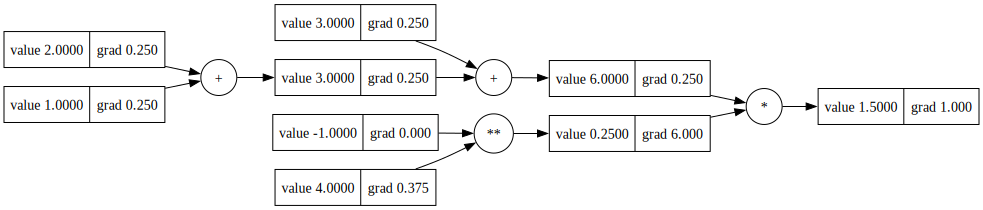

In [57]:
from graphviz import Digraph
from typing import Set

# Set the backend to SVG

# Testing backwards
a = GradientNumber(1)
b = GradientNumber(2)
c = GradientNumber(3)
d = GradientNumber(4)

e = (a + b + c) / d
e.backward()



# Getting edges and nodes
nodes: Set[GradientNumber] = set()
edges: Set[tuple[GradientNumber, GradientNumber]] = set()

def visit(node):
    if node.children:
        nodes.add(node)
        for child in node.children:
            edges.add((node, child))
            visit(child)
    else:
        nodes.add(node)
visit(e)

# Create a Digraph
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

# Add nodes and edges to the Digraph
for node in nodes:
    node_unique_id = str(id(node))
    dot.node(node_unique_id, label = "{ value %.4f | grad %.3f }" % (node.value, node.gradient), shape='record')
    if node.children:
        operator_unique_id = node_unique_id + node.operator
        dot.node(operator_unique_id, label=node.operator, shape='circle')
        dot.edge(operator_unique_id, node_unique_id)
        
for edge in edges:
    
    parent = edge[0]
    child = edge[1]
    parent_unique_id = str(id(parent))
    child_unique_id = str(id(child))

    if parent.children:
        operator_unique_id = parent_unique_id + parent.operator
        dot.edge(child_unique_id, operator_unique_id)
    else:
        dot.edge(child_unique_id, parent_unique_id)

dot
